# _Keyword Spotting_ usando redes convolucionais

## Introdução

_Keyword Spotting_ é uma técnica de detecção de palavras chaves pré-definidas em um falas continuadas [1]. É muito utilizado no contexto de reconhecimento de fala nos _wake word systems_, tal como o "_Ok Google!_" dos dispositivos **Android** [2]. Neste documento, é apresentado uma solução em _Keyword Spotting_ usando redes neurais artificiais convolucionais. 

### _Dataset_

O _dataset_ utilizado no projeto é o **_DARPA TIMIT_**, conhecido na literatura e utilizado em algumas publicações [3-5]. Este _dataset_ é dividido em locutores e por texto, onde o usuário tem acesso aos arquivos `.WAV`, à transcrição e também as indexações por palavras e por fonemas.

Neste trabalho é utilizado as indexações por palavras e também os arquivos `.WAV` contidos no _dataset_.  

### Divisão do _dataset_

O _dataset_ é dividido em dois blocos: treinamento e teste.
A classificação é realizda através de duas classes: palavras fora do vocabulário (**OOV**) e palavra-chave (**KW**)

### _Features_

Para a extração de _features_ dos trechos de áudio, correspondentes a OOV e KW, é utilizado uma matriz de **_Mel Frequency Cepstrum Coefficients_** (MFCC). Cada coluna da matriz representa uma extração MFCC de um subtrecho do trecho de áudio.

Os MFCCs são extraidos a partir dos parametros:
```python
fs = 16000 # taxa de amostragem dos arquivos de audio

n_fft= 512   # tamanho da FFT para extração dos MFCCs
hop_length=0 # pulo entre cada frame
n_mels= 50   # numero de filtros MEL
n_mfcc= 15   # numero de coeficientes MFFC
ofs_mfcc=2   # offset dado para não utilizar os primeiros coeficientes MFCC      

fmin=100    # frequencia mínima do MFCC
fmax=4000   # frequencia máxima do MFCC

n_frames_MFCC = 10 # numero de frames MFCC que será usado para o reconhecimento.

frame_len = (n_frames_MFCC-1)*n_fft # tamanho do frame recortado para cada entrada
frame_lenD2 = int(frame_len/2) # tamanho do frame dividido por 2
```

Para a extração dos MFCCs, é utilizado a biblioteca ```librosa```
```python
import librosa```

### Rede Neural

O treinamento da Rede Neural é realizado utilizando a biblioteca ```keras```
```python
import keras```


## Código

Na sequência é apresentado o código realizado para extração de _features_, treinamento e teste da Rede Neural.

### Declaração de bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa

from scipy.io.wavfile import read as wavread
from scipy.io.wavfile import write as wavwrite

import os, time

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

/home/usrp/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Declaração de _PATHs_

Aqui é declarado os caminhos para que estão armazenados o _dataset_ e onde estará armazenada as _features_ de KW e OOV.

Também é declarado a _keyword_ escolhida.

In [3]:
TRAIN_DIR_TIMIT = 'TRAIN'
TRAIN_DIR_KW = os.path.join('data','train','kw')
TRAIN_DIR_OOV = os.path.join('data','train','oov')
TRAIN_DIR_KW_SMP = os.path.join('data','train','kw_samples')

TEST_DIR_TIMIT = 'TEST'
TEST_DIR_KW = os.path.join('data','test','kw')
TEST_DIR_OOV = os.path.join('data','test','oov')
TEST_DIR_KW_SMP = os.path.join('data','test','kw_samples')

# keyword escolhida
KEYWORD = 'she'

### Declaração de constantes MFCC

Aqui são declaradas as constantes utilizadas na extração de _features_ MFCC dos trechos de áudio.

In [184]:
fs = 16000 # taxa de amostragem dos arquivos de audio

n_fft= 512   # tamanho da FFT para extração dos MFCCs
hop_length=0 # pulo entre cada frame
n_mels= 50   # numero de filtros MEL
n_mfcc= 15   # numero de coeficientes MFFC
ofs_mfcc=2   # offset dado para não utilizar os primeiros coeficientes MFCC      

fmin=100    # frequencia mínima do MFCC
fmax=4000   # frequencia máxima do MFCC

n_frames_MFCC = 15 # numero de frames MFCC que será usado para o reconhecimento.

frame_len = (n_frames_MFCC-1)*n_fft # tamanho do frame recortado para cada entrada
frame_lenD2 = int(frame_len/2) # tamanho do frame dividido por 2

# Extração de _features_

Nesta etapa é extraido as _features_ dos exemplos de áudio do _dataset_ **DARPA TIMIT**

1. Inicialmente, é gerado as pastas que serão armazenadas as _features_

2. Na sequência, é percorrido, através de um ```for```, todas as pastas do _dataset_ **DARPA TIMIT**

3. Posteriormente, é analisado cada arquivo _.WRD_, encontrando exemplos da _keyword_ escolhida através do parâmetro ```KEYWORD```. Em cada exemplo, é extraido dos arquivos _.WAV_ os trechos correspondentes a _keyword_ e realizada a extração dos MFCCs do exemplo.

4. Agora, de forma aleatória, é escolhido ```OOV_N``` exemplos de OOV de cada arquivo de áudio.

5. Finalmente, são salvas as listas que contém as _features_, as matrizes MFCC (OOV e KW), que serão utilizadas no treinamento da rede neural.



In [5]:
DIR = (TRAIN_DIR_TIMIT, TRAIN_DIR_KW, TRAIN_DIR_OOV)

# se nao existe, gera as pastas
if not os.path.isdir(DIR[1]):
    os.makedirs(DIR[1])
if not os.path.isdir(DIR[2]):
    os.makedirs(DIR[2])

# declara as variaveis utilizadas no laço
start = time.time()
print('Inicio em', start)
wrd_list = []
# 2. percorre por todos os arquivos de audio do dataset
for path, dirs, files in os.walk(DIR[0]):
    for file in files:
        # encontra os arquivos .WRD
        if file.endswith('WRD'):
            # .wav
            fullFileName = os.path.join(path, file)
            fnameNoSuffix = os.path.splitext(fullFileName)[0]

            # abre o arquvo .WRD
            text = open(fullFileName,'r')
            for line in text.read().splitlines():
                word = line.split(' ')[2] # adquire a terceira palavra da linha
                wrd_list.append(word) # armazena em uma word list

Inicio em 1530822645.1029563


In [6]:
len([i for i, x in enumerate(wrd_list) if x == "she"])

572

In [7]:
def extract_MFCC_TIMIT(typeDIR='train'):
    if typeDIR=='train':
        DIR = (TRAIN_DIR_TIMIT, TRAIN_DIR_KW, TRAIN_DIR_OOV, TRAIN_DIR_KW_SMP)
    else:
        DIR = (TEST_DIR_TIMIT, TEST_DIR_KW, TEST_DIR_OOV, TEST_DIR_KW_SMP)
    # 1.
    # se nao existe, gera as pastas
    if not os.path.isdir(DIR[1]):
        os.makedirs(DIR[1])
    if not os.path.isdir(DIR[2]):
        os.makedirs(DIR[2])
    if not os.path.isdir(DIR[3]):
        os.makedirs(DIR[3])

    # declara as variaveis utilizadas no laço
    start = time.time()
    print('Inicio em', start)
    cnt = 0
    wrd_list = []
    cnt_kw = 0
    cnt_oov = 0
    OOV_N = 5
    cnt_dirs = 0
    kw_MFCC = []
    oov_MFCC = []
#     kw_lines = []

    f = open(DIR[3] + '/kwds.txt','w')
    
    # 2. percorre por todos os arquivos de audio do dataset
    for path, dirs, files in os.walk(DIR[0]):
    #     kw_MFCC = []
    #     oov_MFCC = []
        for file in files:
            # encontra os arquivos .WRD
            if file.endswith('WRD'):
                # .wav
                fullFileName = os.path.join(path, file)
                fnameNoSuffix = os.path.splitext(fullFileName)[0]

                [data_file, _] = librosa.load(fnameNoSuffix + '.WAV', sr=fs) # Lê todo o arquivo de audio
                N = data_file.shape[0]  # indica o tamanho do arquivo

                # abre o arquvo .WRD
                text = open(fullFileName,'r')
                have_KW = False
                center = 1e12
                # 3.
                # no arquivo .WRD, le todas as linhas
                for line in text.read().splitlines():
                    word = line.split(' ')[2] # adquire a terceira palavra da linha
                    wrd_list.append(word) # armazena em uma word list

                    # se encontrar uma keyword
                    if word == KEYWORD:
#                         kw_lines.append(line+' '+fnameNoSuffix + '.WAV')
                        f.write(line+' '+fnameNoSuffix + '.WAV'+'\n')
                        # encontra o centro da keyword
                        center = int((int(line.split(' ')[0]) + int(line.split(' ')[1]))/2)
                        have_KW = True

                        # verifica se os o frame está dentro dos limites do arquivo de audio
                        # e extrai o trecho de audio contendo a KW
                        if center < frame_lenD2:
                            frameSample = np.concatenate((np.zeros(frame_lenD2-center), data_file[0:center+frame_lenD2]))
                        else:
                            frameSample = data_file[center-frame_lenD2:center+frame_lenD2]

                        # extrai os MFCCs do trecho contendo a KW
                        MFCCsample = librosa.feature.mfcc(y=frameSample, sr=fs, fmin=fmin, fmax=fmax, 
                                                             n_mfcc=n_mfcc, n_mels=n_mels, n_fft=n_fft)

                        # armazena em uma lista
                        kw_MFCC.append(MFCCsample[ofs_mfcc:])
                        # conta o numero de trechos MFCC KW extraidos
                        cnt_kw+=1
                        if cnt_kw<=20:
                            wavwrite(DIR[3]+'/framesKW'+str(cnt_kw)+'.wav', fs, frameSample)

                # 4.
                # executa o laco OOV_N vezes 
                for p in range(OOV_N):
                    goodId = False
                    while goodId == False:
                        # escolhe um indice aleatorio para centro do trecho OOV 
                        # dentro do arquivo de audio
                        idx = np.random.randint(N-frame_len)+frame_lenD2 # gera numero aleatorio
                        goodId = True

    #                     for j in range(len(center)): # analisa o indice criado com os indices das kw
    #                         if abs(idx-iAbre[i][j]) < frame_len:
    #                             goodId = False

                        # se bater com o trecho da KW, escolhe outro
                        if abs(idx-center) < frame_len:
                            goodId = False

                        # extrai o trecho de audio
                        frameSample = data_file[idx-frame_lenD2:idx+frame_lenD2]

                        # extrai os MFCCs
                        MFCCsample = librosa.feature.mfcc(y=frameSample, sr=fs, fmin=fmin, fmax=fmax, 
                                                             n_mfcc=n_mfcc, n_mels=n_mels, n_fft=n_fft)

                        # salva em uma lista
                        oov_MFCC.append(MFCCsample[ofs_mfcc:])

                        # conta o numero de trechos MFCC OOV extraidos
                        cnt_oov+=1
    
    [data_file, _] = librosa.load('../Exemplos_outros/ruido.wav', sr=fs)
    N = data_file.shape[0]
    for i in range(10000):
        idx = np.random.randint(N-frame_len)+frame_lenD2
        
        frameSample = data_file[idx-frame_lenD2:idx+frame_lenD2]
        
        # extrai os MFCCs
        MFCCsample = librosa.feature.mfcc(y=frameSample, sr=fs, fmin=fmin, fmax=fmax, 
                                             n_mfcc=n_mfcc, n_mels=n_mels, n_fft=n_fft)


        oov_MFCC.append(MFCCsample[ofs_mfcc:])
    
#                 if cnt_oov > 200:
#                     break
#         if cnt_oov > 200:
#             break

    #     cnt_dirs += 1
    #     if cnt_dirs == 10:
    #         break

    #     if  kw_MFCC != []:
    #         featFileName = os.path.join(DIR[1], fnameNoSuffix.split(os.sep)[-2] + '-' + fnameNoSuffix.split(os.sep)[-1] + '.npy')
    #     #     featFileName = os.path.join(DIR[1], 'KW_MFCCs.npy')
    #         np.save(featFileName, kw_MFCC)

    #     featFileName = os.path.join(DIR[2], fnameNoSuffix.split(os.sep)[-2] + '-' + fnameNoSuffix.split(os.sep)[-1] + '.npy')
    #     #     featFileName = os.path.join(DIR[2], 'OOV_MFCCs.npy')
    #     np.save(featFileName, oov_MFCC)

    ##### Salva os arquivos e imprimi a duração da extração dos MFCC do dataset
#     file.write('\n'.join([item for item in kw_lines]))
    f.close()
    # featFileName = os.path.join(DIR[1], fnameNoSuffix.split(os.sep)[-2] + '-' + fnameNoSuffix.split(os.sep)[-1] + '.npy')
    featFileName = os.path.join(DIR[1], 'KW_MFCCs.npy')
    np.save(featFileName, kw_MFCC)

    # featFileName = os.path.join(DIR[2], fnameNoSuffix.split(os.sep)[-2] + '-' + fnameNoSuffix.split(os.sep)[-1] + '.npy')
    featFileName = os.path.join(DIR[2], 'OOV_MFCCs.npy')
    np.save(featFileName, oov_MFCC)

    fim = time.time()
    print('Fim em', fim)
    print('\n{}: \n\nKW examples: {}\nOOV examples: {}\n\nduration: {:.0f}s'.format(typeDIR, cnt_kw, cnt_oov, (time.time()-start)))

In [8]:
extract_MFCC_TIMIT(typeDIR='train')

Inicio em 1530822650.104241
Fim em 1530823079.9115534

train: 

KW examples: 572
OOV examples: 23843

duration: 430s


In [9]:
extract_MFCC_TIMIT(typeDIR='test')

Inicio em 1530823079.9603503
Fim em 1530823331.5960865

test: 

KW examples: 208
OOV examples: 8651

duration: 252s


In [73]:
kw_MFCC = np.load(os.path.join(TRAIN_DIR_KW, 'KW_MFCCs.npy'))

In [74]:
oov_MFCC = np.load(os.path.join(TRAIN_DIR_OOV, 'OOV_MFCCs.npy'))

### Exemplos

As figuras abaixo apresentam exemplos das matrizes MFCC, as _features_, geradas na etapa anterior


Aqui é apresentado a matriz MFCC da keyword numero 100 




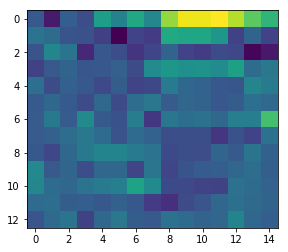

In [75]:
i=100
print('\nAqui é apresentado a matriz MFCC da keyword numero', i, '\n\n')

plt.imshow(kw_MFCC[i])


Aqui é apresentado a matriz MFCC da OOV numero 40 




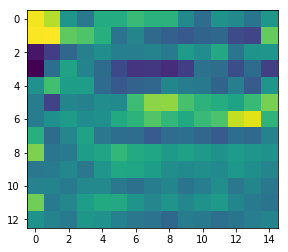

In [76]:
i=40
print('\nAqui é apresentado a matriz MFCC da OOV numero', i, '\n\n')

plt.imshow(oov_MFCC[i])

## _Split Data_

A função abaixo é utilizada para embaralhar e separar o conjunto de dados. 
Neste trabalho, é utilizada apenas para para embaralhar o conjunto de treinamento. 

In [77]:
def splitData(x, y, p=0.2): 
    shapeInX = x.shape
    shapeInY = y.shape
    datax = x.reshape(shapeInX[0],-1)
    
    data = np.concatenate((datax, y), axis=1)
    # random.randint(0, int(x.shape[0]*(1-p)))
    xScrambled = np.random.permutation(data)
    nLines = xScrambled.shape[0]

    data_train = xScrambled[0:int(round(nLines*(1-p))), :]
    data_test = xScrambled[int(round(nLines*(1-p))):, :]
#     print(nLines)
#     print(data_train.shape)
    
    shape_train = np.asarray(shapeInX)
    shape_train[0] = data_train.shape[0]
    x_train = data_train[:,:data_train.shape[1]-shapeInY[1]].reshape(tuple(shape_train))
    y_train = data_train[:,[data_train.shape[1]-shapeInY[1]]]
    
    
    shape_test = np.asarray(shapeInX)
    shape_test[0] = data_test.shape[0]
    x_test = data_test[:,:data_test.shape[1]-shapeInY[1]].reshape(tuple(shape_test))
    y_test = data_test[:,data_test.shape[1]-shapeInY[1]:]
    
    
    return (x_train, y_train), (x_test, y_test)


Embaralha o conjunto as _features_ OOV e KW para gerar os dados de treinamento: ```(x_train, y_train)```

In [78]:
OOV_uses = 5000
oov_MFCC = np.random.permutation(oov_MFCC)[:OOV_uses]

y_OOV = np.zeros((len(oov_MFCC),  1))
y_KW = np.ones((len(kw_MFCC),  1))

(x_train, y_train), _ = splitData(
            np.concatenate((np.array(kw_MFCC), 
                           np.array(kw_MFCC), np.array(oov_MFCC)), axis=0), 
            np.concatenate((np.array(y_KW), 
                           np.array(y_KW), np.array(y_OOV)), axis=0), p=0)

x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
# print(y_train[:300])
print(x_train.shape)

(6144, 13, 15, 1)


## Rede Neural Convolucional

É utilizado neste trabalho uma Rede Neural Convolucional para classificar as _keywords_ e as OOVs.

Em [9] é explorado o uso de _convolutional neural networks_ (CNN)
em sistemas de _keyword spotting_. É apresentado um ganho relativo
de 27-44% de _false reject rate_ comparado com _dense neural networks_
(DNN). Tais comparações foram realizadas observando o número de
parâmetros e multiplicações realizadas, mostrando que as CNNs utilizam muito menos parâmetros e multiplicações.

In [79]:
import keras
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Dropout
from keras.models import Sequential

input_shape = x_train.shape[1:]
num_classes = 2

print(input_shape)
y_train_ce = keras.utils.to_categorical(y_train.reshape(-1), num_classes)

(13, 15, 1)


### Criação do Modelo

Abaixo é declarada a estrutura do modelo da Rede Neural que será utilizada. 

O Sumário do modelo da rede é apresentado na sequência

In [109]:
model = Sequential()
model.add(Conv2D(7, kernel_size=(5, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
# model.add(Conv2D(4, kernel_size=(3, 4), strides=(1, 1),
#                  activation='relu'))
# model.add(Conv2D(3, kernel_size=(2, 4), strides=(1, 1),
#                  activation='relu'))
# model.add(Conv2D(3, kernel_size=(2, 4), strides=(1, 1),
#                  activation='relu'))
model.add(Conv2D(10, kernel_size=(4, 2), strides=(1, 1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(10, kernel_size=(2, 2), strides=(1, 1),
                 activation='relu'))
# model.add(Conv2D(2, kernel_size=(2, 4), strides=(1, 1),
#                  activation='relu',
#                  input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# model.add(Conv2D(4, (2, 2), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
# model.add(Dense(10, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('************************ SUMÁRIO DA REDE ************************\n\n')
model.summary()

************************ SUMÁRIO DA REDE ************************


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 9, 13, 7)          112       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 6, 12, 10)         570       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 6, 10)          0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 2, 5, 10)          410       
_________________________________________________________________
flatten_7 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 202       
Total params: 1,294
Trainable params: 1,294
Non-trainable params: 0
______

In [114]:
class_weight = {0: 1.,
                1: 2.}

history = model.fit(x_train, y_train_ce,
          validation_split=0.1,
          epochs=3,
          batch_size=128,
          class_weight=class_weight,
          verbose=2,
                   )
print('\nNeural Network Trained! \n\n')


Train on 5529 samples, validate on 615 samples
Epoch 1/3
 - 1s - loss: 0.0738 - acc: 0.9799 - val_loss: 0.0869 - val_acc: 0.9789
Epoch 2/3
 - 1s - loss: 0.0636 - acc: 0.9848 - val_loss: 0.0784 - val_acc: 0.9789
Epoch 3/3
 - 1s - loss: 0.0553 - acc: 0.9868 - val_loss: 0.0730 - val_acc: 0.9821

Neural Network Trained! 




## Analise do desempenho 

Neste etapa, é analisado o desempenho da rede neural utilizando o conjunto de teste.

In [180]:
kw_MFCC2 = np.load(os.path.join(TEST_DIR_KW, 'KW_MFCCs.npy'))
oov_MFCC2 = np.load(os.path.join(TEST_DIR_OOV, 'OOV_MFCCs.npy'))

y_OOV = np.zeros((len(oov_MFCC2),  1))
y_KW = np.ones((len(kw_MFCC2),  1))

x_KW = np.array(kw_MFCC2)
x_OOV = np.array(oov_MFCC2)

x_KW = x_KW.reshape(x_KW.shape[0],x_KW.shape[1],x_KW.shape[2],1)
x_OOV = x_OOV.reshape(x_OOV.shape[0],x_OOV.shape[1],x_OOV.shape[2],1)

(x_test, y_test), _ = splitData(
            np.concatenate((x_KW, x_OOV), axis=0), 
            np.concatenate((y_KW, y_OOV), axis=0), p=0)

x_test = x_test

y_test_ce = keras.utils.to_categorical(y_test.reshape(-1), num_classes)
y_OOV_ce  = keras.utils.to_categorical(y_OOV.reshape(-1), num_classes)
y_KW_ce   = keras.utils.to_categorical(y_KW.reshape(-1), num_classes)

In [181]:
scoreTrue = model.evaluate(x_KW, y_KW_ce)
scoreFalse = model.evaluate(x_OOV, y_OOV_ce)

print('\nScore True of model with test KW dataset:', 100*scoreTrue[1],'%\n')
print('Score False of model with test OOV dataset:', 100*scoreFalse[1],'%\n')

18651/18651 [==============================] - 3s 138us/step

Score True of model with test KW dataset: 89.90384615384616 %

Score False of model with test OOV dataset: 98.6917591550051 %



## Teste usando um audio qualquer

In [182]:
import scipy

def testNetWith(file, model, stride=512):
       
# stride = 1000
# file = '../Exemplos_outros/Henrique_abre.wav'
    data_file, _ = librosa.load(file, sr=fs) # Lê todo o arquivo de audio
    N = data_file.shape[0]
    data_file = data_file/32767

    data_pred_out = np.zeros(N)

    center = 0
    while(center<N):
        MFCCsample = []
        # verifica se os o frame está dentro dos limites do arquivo de audio
        # e extrai o trecho de audio contendo a KW
        if center < frame_lenD2:
            frameSample = np.concatenate((np.zeros(frame_lenD2-center), data_file[0:center+frame_lenD2]))
        elif (N-center) < frame_lenD2:
            frameSample = np.concatenate((data_file[center-frame_lenD2:],np.zeros(frame_lenD2 - (N-center))))
        else:
            frameSample = data_file[center-frame_lenD2:center+frame_lenD2]
        # frameSample.shape, frame_lenD2


        MFCCsample.append(librosa.feature.mfcc(y=frameSample, sr=fs, fmin=fmin, fmax=fmax, 
                                     n_mfcc=n_mfcc, n_mels=n_mels, n_fft=n_fft)[ofs_mfcc:])

        data_in = np.array(MFCCsample)#reshape(1,13,10,1)
        data_in = data_in.reshape(data_in.shape[0], data_in.shape[1], data_in.shape[2], 1) 

        y_out = model.predict(data_in)

        if (center+stride<=N):
#             data_pred_out[center:center+stride] = y_out[0,1] 
#             data_pred_out[center:center+100] =  y_out[0,1] 
            data_pred_out[center] = y_out[0,1]#ound(y_out[0,1]) 
        else:
#             data_pred_out[center:] =  y_out[0,1]
#             data_pred_out[center] =  y_out[0,1]
            data_pred_out[center] =  y_out[0,1]#ound(y_out[0,1])

        center += stride        
    
    return data_pred_out

### Teste em um sinal continuo

Neste teste, é realizada a classificação, analisando um passo dado pelo ```stride```

PS: não é utilizado filtro de _smoothing_ para melhorar a detecção

In [ ]:
model.save('model_en.flv')

In [176]:
model = keras.models.load_model('model_en.flv')

In [185]:
file = '../Exemplos_outros/she_natan3.wav'
data_ex = testNetWith(file, model, stride=128)

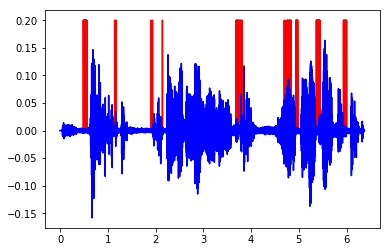

In [187]:
data_file, _ = librosa.load(file, sr=fs) # Lê todo o arquivo de audio
N = data_file.shape[0]

data_file = data_file
t = np.linspace(0,N/fs,N)

data_ex = data_ex.round()
data_ex_2 = np.convolve(data_ex, np.ones(4000)/128, 'same')

data_ex_3 = np.zeros(N)
data_ex_3[data_ex_2>0.125] = data_ex_2[data_ex_2>0.125]

look = [0,
        400000]

plt.plot(t[look[0]:look[1]], data_ex[look[0]:look[1]]*0.2, 'r', 
          t[look[0]:look[1]], data_file[look[0]:look[1]], 'b')

#### Utilizando filtro de _Smoothing_

Neste teste, é realizada a classificação, analisando um passo dado pelo ```stride```, mas agora utilizando filtro de _smoothing_ para melhorar a detecção.

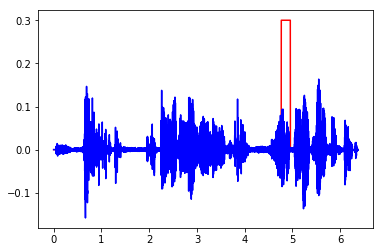

In [188]:
tres = 0.1
data_ex_2 = np.convolve(data_ex, np.ones(6000)/128, 'same')

data_ex_3 = np.zeros(N)
data_ex_3[data_ex_2>tres] = 1


look = [0,
        400000]

plt.plot(t[look[0]:look[1]], data_ex_3[look[0]:look[1]]*0.3, 'r', 
          t[look[0]:look[1]], data_file[look[0]:look[1]], 'b')

In [189]:
import IPython.display as ipd
ipd.Audio(file) # load a local WAV file

## Usando _dataset_ em portugues

In [127]:
PATH_PORT_DATASET = '../Dataset_idx'
CSV_DATASET = os.path.join(PATH_PORT_DATASET, 'Dataset_idx.csv') 



df = pd.read_csv(CSV_DATASET)
df.head()

,Unnamed: 0,type,recOOV,file,idx_abre,Unnamed: 5
0,0,MISC,100,Estevan_3.wav,[4730 76320 131880 180000 212000],NaN
1,1,MISC,100,Marina_1.wav,[29450 106430 165400 214060 330190],NaN
2,2,MISC,100,Marina_4.wav,[12170 82450 138570 180800 218120 280850 347250],NaN
3,3,MISC,100,Marina_6.wav,[25130 57970 125860 199900 239820 277720 33808...,NaN
4,4,MISC,100,Natan_1.wav,[25670 107110 162700 208770 332250],NaN


## Formata as colunas de indexação em formatos de lista 

In [128]:
x = df['idx_abre']
iAbre = {}
for i in range(len(x)):
    p = x[i]
    p = p.replace('[','')
    p = p.replace(']','')
    
    p = p.split(' ')
#     print(p)
    if p[0] != '':
        iAbre[i] = list(map(int, p))
    else:
        iAbre[i] = list(map(int,[-1e9])) 

In [129]:
iAbre[0]

[4730, 76320, 131880, 180000, 212000]

## Definição das constantes

Com índices de cada arquivo de audio para cada palavra-chave, temos o centro de cada _frame_ que conterá as respectivas palavras-chave. 

Então, agora é preciso configurar todos os parâmetros para extração de _feature_ para a entrada. 
Isso ocorre pois estes parâmetros alterarão os tamanhos de _frames_ que serão agora coletados para cada _keyword_   

In [190]:
fs = 8000 # taxa de amostragem dos arquivos de audio

n_fft= 512   # tamanho da FFT para extração dos MFCCs
hop_length=0 # pulo entre cada frame
n_mels= 50   # numero de filtros MEL
n_mfcc= 15   # numero de coeficientes MFFC
ofs_mfcc=2   # offset dado para não utilizar os primeiros coeficientes MFCC      

fmin=100    # frequencia mínima do MFCC
fmax=4000   # frequencia máxima do MFCC

n_frames_MFCC = 10 # numero de frames MFCC que será usado para o reconhecimento.

frame_len = (n_frames_MFCC-1)*n_fft # tamanho do frame recortado para cada entrada
frame_lenD2 = int(frame_len/2) # tamanho do frame dividido por 2

## Extração das _Features_ que contém a palavra-chave

Agora que todas as constantes necessárias ja foram declaradas, é extraído de cada arquivo de áudio os _frames_ contendo a palavras-chave, conforme indexado por `iAbre[i]`.

Após extraído tais _frames_, é realizado o cálculo do MFCC para a extração das _features_ de cada _frame_.

In [131]:
frameMFCC = {}
kwFeat = {}
for i in range(len(df['file'])):
    wavstr = os.path.join(PATH_PORT_DATASET, df['file'][i])  # extrai a string contendo o nome do arquivo de audio
    [_, data_file] = wavread(wavstr) # Lê todo o arquivo de audio

    data_file = data_file/32767 # normaliza as amostras do  áudio para o range [-1,1]
    N = data_file.shape[0]      # indica o tamanho do arquivo

#     # quando necessário é plotado o áudio do arquivo 
#     t = np.linspace(0, N/fs, N)
#     plt.plot(t, data_file)
    for j in range(len(iAbre[i])): # para cada audio, retira os frames kw e as features
        if iAbre[i][j] < 0:
            break
        
        frameSample = data_file[iAbre[i][j]-frame_lenD2:iAbre[i][j]+frame_lenD2]
        MFCCsample = librosa.feature.mfcc(y=frameSample, sr=fs, fmin=fmin, fmax=fmax, 
                                             n_mfcc=n_mfcc, n_mels=n_mels, n_fft=n_fft)

        frameMFCC[j] = MFCCsample[ofs_mfcc:]
    
    kwFeat[i] = frameMFCC

number of keyword inputs: 106
number of keyword test inputs: 16


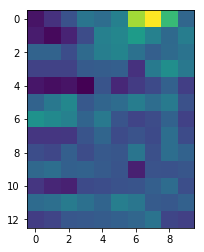

In [132]:
lenKW_1 = 0
for i in range(len(df['file'])):
    if df['file'][i].find('Vitor') == -1:
        for j in range(len(iAbre[i])):
            if iAbre[i][j] < 0:
                break
            
            lenKW_1=lenKW_1+1

lenKW_1_test = 0
for i in range(len(df['file'])):
    if df['file'][i].find('Vitor') != -1:
        for j in range(len(iAbre[i])):
            if iAbre[i][j] < 0:
                break
            
            lenKW_1_test=lenKW_1_test+1
            
print('number of keyword inputs:',lenKW_1)
print('number of keyword test inputs:',lenKW_1_test)
imgplot = plt.imshow(kwFeat[0][7])

## Extração dos indices e das _Features_ _Out of Vocabulary_

Para treinar a rede, é necessário utilizar exemplos do que não é as palavras-chave, chamadas de _Out Of Vocabulary Word_ (OOV _words_).
Então, é indexado aleatoriamente trechos dos áudios contendo palavras OOV, para posteriormente a extração das _features_.

In [133]:
# OOV_lenght = 100 # gera OOV_length OutOfVoc frames por audio
OOV_lenght = list(map(int,df['recOOV'])) # gera OOV_length OutOfVoc frames por audio
iOOV = {}
# iOOVk = np.zeros(OOV_lenght)

for i in range(len(df['file'])):
    wavstr =  os.path.join(PATH_PORT_DATASET, df['file'][i])  # extrai a string contendo o nome do arquivo de audio
    [_, data_file] = wavread(wavstr) # Lê todo o arquivo de audio

    data_file = data_file/32767 # normaliza as amostras do  áudio para o range [-1,1]
    N = data_file.shape[0]      # indica o tamanho do arquivo
#     print(N)
    
    iOOVk = np.zeros(OOV_lenght[i]*2)

    for k in range(OOV_lenght[i]*2):
        # tenta adquirir indices que indicam frames com Out Of Voc words
        # de forma aleatoria
        goodId = False
        while goodId == False:
            idx = np.random.randint(N-frame_len)+frame_lenD2 # gera numero aleatorio
            goodId = True
            for j in range(len(iAbre[i])): # analisa o indice criado com os indices das kw
                if abs(idx-iAbre[i][j]) < frame_len:
                    goodId = False
        
        iOOVk[k] = idx
            
    iOOV[i] = iOOVk.astype(int)

### Gera arquivo de audio contendo os trechos OOV para analise

In [134]:
i=2
wavstr = os.path.join(PATH_PORT_DATASET, df['file'][i])  # extrai a string contendo o nome do arquivo de audio
[_, data_file] = wavread(wavstr) # Lê todo o arquivo de audio

data_file = data_file/32767 # normaliza as amostras do  áudio para o range [-1,1]
N = data_file.shape[0]      # indica o tamanho do arquivo

#     # quando necessário é plotado o áudio do arquivo 
#     t = np.linspace(0, N/fs, N)
#     plt.plot(t, data_file)

frameSample = np.zeros((frame_len,len(iOOV[i])))
for j in range(len(iOOV[i])): # para cada audio, retira os frames kw e as features
    frameSample[:,j] = data_file[iOOV[i][j]-frame_lenD2:iOOV[i][j]+frame_lenD2]

frameSample = frameSample.T.reshape(-1)
wavwrite('framesOOV.wav', fs, frameSample)

### Extração das Features OOV

In [135]:
frameMFCC = {}
oovFeat = {}
for i in range(len(df['file'])):
    wavstr = os.path.join(PATH_PORT_DATASET, df['file'][i])  # extrai a string contendo o nome do arquivo de audio
    [_, data_file] = wavread(wavstr) # Lê todo o arquivo de audio

    data_file = data_file/32767 # normaliza as amostras do  áudio para o range [-1,1]
    N = data_file.shape[0]      # indica o tamanho do arquivo

#     # quando necessário é plotado o áudio do arquivo 
#     t = np.linspace(0, N/fs, N)
#     plt.plot(t, data_file)
    for j in range(len(iOOV[i])): # para cada audio, retira os frames kw e as features
        frameSample = data_file[iOOV[i][j]-frame_lenD2:iOOV[i][j]+frame_lenD2]
        
        MFCCsample = librosa.feature.mfcc(y=frameSample, sr=fs, fmin=fmin, fmax=fmax, 
                                             n_mfcc=n_mfcc, n_mels=n_mels, n_fft=n_fft)
        
        frameMFCC[j] = MFCCsample[ofs_mfcc:]
    
    oovFeat[i] = frameMFCC

number of out-of-voc inputs: 4280
number of out-of-voc test inputs: 640


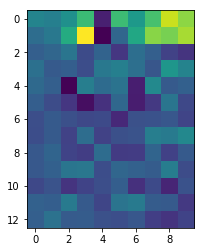

In [136]:
lenOOV = 0
for i in range(len(df['file'])):
    if df['file'][i].find('Vitor') == -1:
        for j in range(len(iOOV[i])):
            lenOOV=lenOOV+1

lenOOVtest = 0
for i in range(len(df['file'])):
    if df['file'][i].find('Vitor') != -1:
        for j in range(len(iOOV[i])):
            lenOOVtest=lenOOVtest+1
            
print('number of out-of-voc inputs:', lenOOV)
print('number of out-of-voc test inputs:', lenOOVtest)

imgplot = plt.imshow(oovFeat[0][99])

# Preparando o _Data Array_

Neste ponto é gerado _arrays_ para dados de treinamento e de teste.

Para isso, é atribuido _arrays_ de elementos OOV e elementos KW, concatenados, embaralhados, e separados em dados de treinamento e de teste.   

In [137]:
# gera os arrays OOV e KW, com suas respectivas labels
x_OOV = np.zeros((lenOOV, oovFeat[0][0].shape[0], oovFeat[0][0].shape[1],1))
x_KW_1 = np.zeros((lenKW_1, oovFeat[0][0].shape[0], oovFeat[0][0].shape[1],1))

x_OOV_test = np.zeros((lenOOVtest, oovFeat[0][0].shape[0], oovFeat[0][0].shape[1],1))
x_KW_1_test = np.zeros((lenKW_1_test, oovFeat[0][0].shape[0], oovFeat[0][0].shape[1],1))

# y_OOV = np.concatenate((np.ones((lenOOV, 1)), np.zeros((lenOOV,  1))), axis=1)
# y_KW_1 = np.concatenate((np.zeros((lenKW_1,  1)), np.ones((lenKW_1, 1))), axis=1)
y_OOV = np.zeros((lenOOV,  1))
y_KW_1 = np.ones((lenKW_1, 1))

y_OOV_test = np.zeros((lenOOVtest,  1))
y_KW_1_test = np.ones((lenKW_1_test, 1))

k=0
m=0
for i in range(len(df['file'])):
    if df['file'][i].find('Vitor') == -1:
        for j in range(len(iOOV[i])): 
            x_OOV[k,:,:,0] = oovFeat[i][j]
            k=k+1
    else:
        for j in range(len(iOOV[i])): 
            x_OOV_test[m,:,:,0] = oovFeat[i][j]
            m=m+1
        

k=0
m=0
for i in range(len(df['file'])):
    if df['file'][i].find('Vitor') == -1:
        for j in range(len(iAbre[i])):
            if iAbre[i][j] < 0:
                break
            x_KW_1[k,:,:,0] = kwFeat[i][j]
            k=k+1
    else:
        for j in range(len(iAbre[i])): 
            if iAbre[i][j] < 0:
                break
                
            x_KW_1_test[m,:,:,0] = kwFeat[i][j]
            m=m+1

print('Keyword Abre Array Shape:', x_KW_1.shape)
print('Out Of Voc Array Shape:', x_OOV.shape)
        
x = np.concatenate((x_OOV, x_KW_1), axis=0)
y = np.concatenate((y_OOV, y_KW_1), axis=0)

print('\nConcatenate Array Shape:', x.shape)

# print(x.shape)
# print(x_OOV.shape)
# print(x_KW_1.shape)
# print(y.shape)
# print(y_OOV.shape)
# print(y_KW_1.shape)

(x_train, y_train), (x_test, y_test) = splitData(x, y, p=0.1)
print('\nTrain data shape:', x_train.shape)
print('Test data shape:', x_test.shape)

# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(y_test.shape)

print('\ncounting of Truth keywords in Test Data:', list(y_test[:]).count(1))
print('counting of OOV words in Test Data:', list(y_test[:]).count(0))

Keyword Abre Array Shape: (106, 13, 10, 1)
Out Of Voc Array Shape: (4280, 13, 10, 1)

Concatenate Array Shape: (4386, 13, 10, 1)

Train data shape: (3947, 13, 10, 1)
Test data shape: (439, 13, 10, 1)

counting of Truth keywords in Test Data: 9
counting of OOV words in Test Data: 430


In [138]:
prepros_feat = [fs,# = 16000 # taxa de amostragem dos arquivos de audio
                n_fft,#= 512   # tamanho da FFT para extração dos MFCCs
                hop_length,#=0 # pulo entre cada frame
                n_mels,#= 50   # numero de filtros MEL
                n_mfcc,#= 16   # numero de coeficientes MFCC
                ofs_mfcc,#=2   # offset dado para não utilizar os primeiros coeficientes MFCC      
                fmin,#=100    # frequencia mínima do MFCC
                fmax,#=4000   # frequencia máxima do MFCC
                n_frames_MFCC,# = 10 # numero de frames MFCC que será usado para o reconhecimento.]
                frame_len, #= (n_frames_MFCC-1)*n_fft # tamanho do frame recortado para cada entrada
                frame_lenD2 #= int(frame_len/2) # tamanho do frame dividido por 2
                ]

Rede = {}
Rede['preFeat'] = prepros_feat
Rede['x_train'] = x_train
Rede['y_train'] = y_train
Rede['x_test'] = x_test
Rede['y_test'] = y_test

# Rede['Model'] = model
# Rede['History'] = history
# Rede = [prepros_feat, [x_train, y_train, x_test, y_test]]

# pickle.dump( Rede, open( 'RedeTeste1.pickle', 'wb' ) )
np.save("DataSet1.npy", Rede)


In [191]:
Rede = np.load("DataSet1.npy").item()

# prepros_feat 	= Rede['preFeat']  
# x_train 		= Rede['x_train']
# y_train			= Rede['y_train'] 
# x_test 			= Rede['x_test'] 
# y_test 			= Rede['y_test']
prepros_feat 	= Rede['preFeat']  
x_train 		= Rede['x_train']
y_train			= Rede['y_train'] 
x_test 			= Rede['x_test'] 
y_test 			= Rede['y_test']

fs = prepros_feat[0] # = 16000 # taxa de amostragem dos arquivos de audio
n_fft = prepros_feat[1] #= 512   # tamanho da FFT para extração dos MFCCs
hop_length = prepros_feat[2] #=0 # pulo entre cada frame
n_mels = prepros_feat[3] #= 50   # numero de filtros MEL
n_mfcc = prepros_feat[4] #= 16   # numero de coeficientes MFCC
ofs_mfcc = prepros_feat[5] #=2   # offset dado para não utilizar os primeiros coeficientes MFCC      
fmin = prepros_feat[6] #=100    # frequencia mínima do MFCC
fmax = prepros_feat[7] #=4000   # frequencia máxima do MFCC
n_frames_MFCC = prepros_feat[8] # = 10 # numero de frames MFCC que será usado para o reconhecimento.]
frame_len = prepros_feat[9]
frame_lenD2 = prepros_feat[10]

# Test with Convolutional Layers

In [200]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten

input_shape = x_train.shape[1:]
num_classes = 2

# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

print(input_shape)
model = Sequential()
model.add(Conv2D(3, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


print('************************ SUMÁRIO DA REDE ************************\n\n')
model.summary()

(13, 10, 1)
************************ SUMÁRIO DA REDE ************************


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 11, 8, 3)          30        
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 5, 4, 3)           0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 60)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 122       
Total params: 152
Trainable params: 152
Non-trainable params: 0
_________________________________________________________________


In [201]:
model.fit(x_train, y_train,
          epochs=20,
          batch_size=128,
          verbose=2)

Epoch 1/20
 - 1s - loss: 0.7056 - acc: 0.8366
Epoch 2/20
 - 0s - loss: 0.1705 - acc: 0.9683
Epoch 3/20
 - 0s - loss: 0.1128 - acc: 0.9729
Epoch 4/20
 - 0s - loss: 0.0736 - acc: 0.9769
Epoch 5/20
 - 0s - loss: 0.0532 - acc: 0.9840
Epoch 6/20
 - 0s - loss: 0.0421 - acc: 0.9916
Epoch 7/20
 - 0s - loss: 0.0356 - acc: 0.9929
Epoch 8/20
 - 0s - loss: 0.0306 - acc: 0.9929
Epoch 9/20
 - 0s - loss: 0.0270 - acc: 0.9929
Epoch 10/20
 - 0s - loss: 0.0240 - acc: 0.9934
Epoch 11/20
 - 0s - loss: 0.0213 - acc: 0.9967
Epoch 12/20
 - 0s - loss: 0.0194 - acc: 0.9977
Epoch 13/20
 - 0s - loss: 0.0175 - acc: 0.9977
Epoch 14/20
 - 0s - loss: 0.0159 - acc: 0.9977
Epoch 15/20
 - 0s - loss: 0.0145 - acc: 0.9977
Epoch 16/20
 - 0s - loss: 0.0132 - acc: 0.9977
Epoch 17/20
 - 0s - loss: 0.0122 - acc: 0.9977
Epoch 18/20
 - 0s - loss: 0.0112 - acc: 0.9977
Epoch 19/20
 - 0s - loss: 0.0104 - acc: 0.9982
Epoch 20/20
 - 0s - loss: 0.0096 - acc: 0.9990


In [202]:
print(x_test.shape)
y_KW = y_test[y_test[:,0] == 1, :]
x_KW = x_test[y_test[:,0] == 1,:,:,:]

y_OOV = y_test[y_test[:,0] == 0, :]
x_OOV = x_test[y_test[:,0] == 0,:,:,:]

scoreTrue = model.evaluate(x_KW, y_KW)
scoreFalse = model.evaluate(x_OOV, y_OOV)

print('\nScore True of model with test KW dataset:', 100*scoreTrue[1],'%\n')
print('Score False of model with test OOV dataset:', 100*scoreFalse[1],'%\n')

(439, 13, 10, 1)
430/430 [==============================] - 0s 85us/step

Score True of model with test KW dataset: 100.0 %

Score False of model with test OOV dataset: 99.76744186046511 %



In [205]:
model.save('model_pt.flv')

In [203]:
def testNetWith(file, model, stride=512):
       
# stride = 1000
# file = '../Exemplos_outros/Henrique_abre.wav'
    [_, data_file] = wavread(file) # Lê todo o arquivo de audio
    N = data_file.shape[0]
    data_file = data_file/32767

    data_pred_out = np.zeros(N)

    center = 4000
#     frameSample = 0
    while((center + frame_lenD2)<N):
        MFCCsample = []
        # verifica se os o frame está dentro dos limites do arquivo de audio
        # e extrai o trecho de audio contendo a KW
#         if center < frame_lenD2:
#             frameSample = np.concatenate((np.zeros(frame_lenD2-center), data_file[0:center+frame_lenD2]))
#         elif (N-center) < frame_lenD2:
#             frameSample = np.concatenate((data_file[center-frame_lenD2:],np.zeros(frame_lenD2 - (N-center))))
#         else:
        frameSample = data_file[center-frame_lenD2:center+frame_lenD2]
        # frameSample.shape, frame_lenD2


        data_in = np.array(librosa.feature.mfcc(y=frameSample, sr=fs, fmin=fmin, fmax=fmax, 
                                     n_mfcc=n_mfcc, n_mels=n_mels, n_fft=n_fft)[ofs_mfcc:]).reshape(1,13,10,1)

        y_out = model.predict(data_in)

        if (center+stride<=N):
#             data_pred_out[center:center+stride] = round(y_out[0,1]) 
            data_pred_out[center] = round(y_out[0,1]) 
        else:
#             data_pred_out[center:] =  round(y_out[0,1])
            data_pred_out[center] =  round(y_out[0,1])

        center += stride        
    
    return data_pred_out

# y_out[0,1]

In [204]:
# file = '../Dataset_idx/Vitor_kw.wav'
file = '../Exemplos_outros/Natan_abre2.wav'
data_ex = testNetWith(file, model, stride=128)

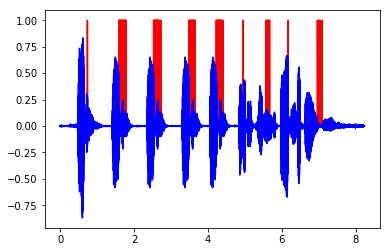

In [172]:
[_, data_file] = wavread(file) # Lê todo o arquivo de audio
N = data_file.shape[0]

data_file = data_file/32767
t = np.linspace(0,N/fs,N)

look = [0,
        400000]

plt.plot(t[look[0]:look[1]], data_ex[look[0]:look[1]], 'r', 
         t[look[0]:look[1]], data_file[look[0]:look[1]], 'b')

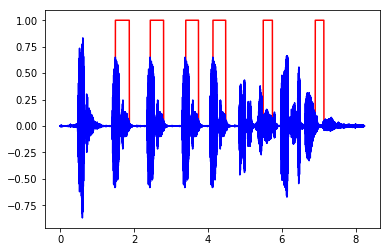

In [173]:
tres = 0.02
data_ex_2 = np.convolve(data_ex, np.ones(2000)/128, 'same')

data_ex_3 = np.zeros(N)
data_ex_3[data_ex_2>tres] = 1


look = [0,
        400000]

plt.plot(t[look[0]:look[1]], data_ex_3[look[0]:look[1]], 'r', 
          t[look[0]:look[1]], data_file[look[0]:look[1]], 'b')

In [207]:
import IPython.display as ipd
ipd.Audio(file) # load a local WAV file